### Notes:

* python script stores result of the simulation in a predetermined location
* jupyter notebook shows visualizations of the results from solidity implementation and cadCAD model and error metrics

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import datetime as dt
from enum import Enum
import csv

import sys
sys.path.append('./models')

In [2]:
# market_price_df = pd.read_csv('./test/data/regression_market_prices.csv')
# market_price_df = pd.read_csv('./test/data/market_prices.csv')
# market_prices = market_price_df['market_price'].apply(lambda x: float(x)).to_list()

import csv
with open('./test/data/historic_market_prices.csv', newline='') as f:
    reader = csv.reader(f)
    market_prices = list(reader)[0]
    market_prices = [float(price) for price in market_prices]

# with open('./test/data/historic_market_prices.csv', 'w') as market_prices_csv:
#     wr = csv.writer(market_prices_csv, delimiter=',')
#     wr.writerow(market_prices)

In [3]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = -.25/3600/96
Ki = 0
    
length = len(market_prices)
delta_t = [3600] * length
SIMULATION_TIMESTEPS = length - 1

# save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
save_dir = "../truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp*1e18)),
  "Ki": str(int(Ki*1e18)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": "1000000000000000000000000000",
  "oracle_initial_price": "2000000000000000000",
  "initial_redemption_price": "2000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

import json
with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "kp": Kp,
  "ki": lambda control_period=3600: Ki/control_period,
  #"noise_barrier": 1000000000000000000,
  #"per_second_leak": 1000000000000000000000000000,
  #"oracle_initial_price": 2000000000000000000,
  #"initial_redemption_price": 2000000000000000000000000000,
  "delta_t": delta_t,
  "market_prices": market_prices,
}

In [4]:
market_prices[0:5]

[2.03520968321892,
 2.00675297061406,
 2.02594470965992,
 2.05147525236802,
 1.94445601467646]

In [5]:
# Compile, test, and deploy contracts to Ganache
# !npm run pi-raw-second-imported-config --prefix './cross-model/truffle'

import os
os.chdir('./cross-model/truffle')
!npm run pi-raw-second-imported-config
import os
os.chdir('../../')


> geb-rrfm-truffle-sims@1.0.0 pi-raw-second-imported-config /Users/bscholtz/workspace/reflexer/cross-model/truffle
> npx truffle test test/pi_raw_second_imported_config.js

░░░░⠂⠂⠂⠂⠂⠂⸩ ⠙ build:chokidar: sill linkStuff chokidar@3.4.2 is install- Fetching solc version list from solc-bin. Attempt #1

Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/mock/AGUpdater.sol
> Compiling ./cross-model/truffle/contracts/mock/MockOracleRelayer.sol
> Compiling ./cross-model/truffle/contracts/mock/MockRateSetter.sol
> Compiling ./cross-model/truffle/contracts/mock/MockTreasury.sol
> Compiling ./cross-model/truffle/contracts/mock/SeedProposerUpdater.sol
> Compiling ./cross-model/truffle/contracts/oracle/MockFeed.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetter.sol
> Compiling ./cross-model/truffle/contracts/setter/RateSetterMath.sol
> Compiling ./cross-model/truffle/contracts/token/Address.sol
> Compilin

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [6]:
from models.system_model.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [7]:
from models.system_model.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [8]:
# T = 0
# for k in config_file.keys():
#     if type(config_file[k]) == list:
#         T = len(config_file[k])-1
#         break

In [9]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [10]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(SIMULATION_TIMESTEPS),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 24, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.34s


In [11]:
full = pd.DataFrame(raw_result)

In [12]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [13]:
save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [14]:
df

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,2.000000,2.000000,0,2018-12-18 00:00:00,0,0,0,1,0,0
6,-0.006753,-0.006172,0.0,0.0,-12.155347,-11.109517,-0.000002,-0.000002,4.884961e-09,2.000035,2.006753,2.000581,3600,2018-12-18 01:00:00,240,0,0,1,6,1
12,-0.025910,-0.024957,0.0,0.0,-70.792515,-67.141465,-0.000005,-0.000005,1.874243e-08,2.000170,2.025945,2.000988,3600,2018-12-18 02:00:00,480,0,0,1,6,2
18,-0.051305,-0.050895,0.0,0.0,-208.986398,-203.674006,-0.000007,-0.000007,3.711308e-08,2.000437,2.051475,2.000581,3600,2018-12-18 03:00:00,720,0,0,1,6,3
24,0.055981,0.056239,0.0,0.0,-199.582774,-194.053887,0.000030,0.000030,-4.049578e-08,2.000146,1.944456,2.000695,3600,2018-12-18 04:00:00,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,-0.043292,-0.098806,0.0,0.0,-1246.482744,-50981.367380,-0.000005,-0.000005,3.131687e-08,1.999742,2.042810,1.944003,3600,2019-01-13 23:00:00,155280,0,0,1,6,647
3888,-0.014949,-0.071941,0.0,0.0,-1345.833865,-51288.713479,0.000008,0.000008,1.081350e-08,1.999820,2.014691,1.942750,3600,2019-01-14 00:00:00,155520,0,0,1,6,648
3894,-0.022192,-0.077961,0.0,0.0,-1406.853638,-51558.537694,-0.000002,-0.000002,1.605347e-08,1.999936,2.022013,1.944052,3600,2019-01-14 01:00:00,155760,0,0,1,6,649
3900,-0.027272,-0.083673,0.0,0.0,-1490.035221,-51849.479583,-0.000001,-0.000001,1.972779e-08,2.000078,2.027208,1.943534,3600,2019-01-14 02:00:00,156000,0,0,1,6,650


In [15]:
data

,MarketPrice(WAD),RedemptionPrice(RAY),RedemptionRate(%),PerSecondRedemptionRate(RAY),RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time,timestamp
0,2.035210e+18,2.000000e+27,1.0,1.000000e+27,1.0,-3.520968e+25,2.546997e+19,0.000000e+00,0.0,3600.0,2.035210,2,2.547e-08,3600.0,2018-12-18 01:00:00
1,2.006753e+18,2.000183e+27,1.0,1.000000e+27,1.0,-6.569578e+24,4.752299e+18,-7.520267e+28,0.0,3600.0,2.006753,2.00018,4.7523e-09,7200.0,2018-12-18 02:00:00
2,2.025945e+18,2.000218e+27,1.0,1.000000e+27,1.0,-2.572710e+25,1.861046e+19,-1.333367e+29,0.0,3600.0,2.025945,2.00022,1.86105e-08,10800.0,2018-12-18 03:00:00
3,2.051475e+18,2.000352e+27,1.0,1.000000e+27,1.0,-5.112362e+25,3.698178e+19,-2.716841e+29,0.0,3600.0,2.051475,2.00035,3.69818e-08,14400.0,2018-12-18 04:00:00
4,1.944456e+18,2.000618e+27,1.0,1.000000e+27,1.0,5.616195e+25,-4.062641e+19,-2.626151e+29,0.0,3600.0,1.944456,2.00062,-4.06264e-08,18000.0,2018-12-18 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2.042810e+18,1.999523e+27,1.0,1.000000e+27,1.0,-4.328611e+25,3.131229e+19,3.148151e+29,0.0,3600.0,2.042810,1.99952,3.13123e-08,2332800.0,2019-01-14 00:00:00
648,2.014691e+18,1.999749e+27,1.0,1.000000e+27,1.0,-1.494222e+25,1.080890e+19,2.099750e+29,0.0,3600.0,2.014691,1.99975,1.08089e-08,2336400.0,2019-01-14 01:00:00
649,2.022013e+18,1.999827e+27,1.0,1.000000e+27,1.0,-2.218599e+25,1.604889e+19,1.431442e+29,0.0,3600.0,2.022013,1.99983,1.60489e-08,2340000.0,2019-01-14 02:00:00
650,2.027208e+18,1.999942e+27,1.0,1.000000e+27,1.0,-2.726539e+25,1.972323e+19,5.413176e+28,0.0,3600.0,2.027208,1.99994,1.97232e-08,2343600.0,2019-01-14 03:00:00


In [16]:
combined = df.merge(data, how='inner', on=['timestamp'])
combined = combined.iloc[25:]
combined

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,...,RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time
25,-0.017458,-0.020879,0.0,0.0,-2663.341434,-2955.080879,-6.713919e-06,-6.713919e-06,1.262853e-08,2.004076,...,1.0,6.874787e+24,-4.973081e+18,-2.811925e+30,0.0,3600.0,1.997307,2.00418,-4.97308e-09,93600.0
26,-0.007315,-0.011896,0.0,0.0,-2696.590546,-3014.074509,2.817451e-06,2.817451e-06,5.291414e-09,2.004114,...,1.0,-1.729614e+25,1.251167e+19,-2.830692e+30,0.0,3600.0,2.021442,2.00415,1.25117e-08,97200.0
27,-0.002192,-0.007209,0.0,0.0,-2702.112665,-3048.462151,1.422963e-06,1.422963e-06,1.585782e-09,2.004125,...,1.0,-7.154147e+24,5.175165e+18,-2.874703e+30,0.0,3600.0,2.011391,2.00424,5.17516e-09,100800.0
28,0.025910,0.021573,0.0,0.0,-2648.307916,-3022.606166,7.806165e-06,7.806165e-06,-1.874277e-08,2.003990,...,1.0,-2.032318e+24,1.470137e+18,-2.891238e+30,0.0,3600.0,2.006306,2.00427,1.47014e-09,104400.0
29,0.028586,0.022963,0.0,0.0,-2538.907639,-2942.441407,7.432600e-07,7.432600e-07,-2.067835e-08,2.003841,...,1.0,2.606905e+25,-1.885782e+19,-2.847977e+30,0.0,3600.0,1.978215,2.00428,-1.88578e-08,108000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,-0.043292,-0.098806,0.0,0.0,-1246.482744,-50981.367380,-5.458344e-06,-5.458344e-06,3.131687e-08,1.999742,...,1.0,-2.363604e+25,1.709783e+19,4.352750e+29,0.0,3600.0,2.023036,1.9994,1.70978e-08,2329200.0
647,-0.014949,-0.071941,0.0,0.0,-1345.833865,-51288.713479,7.873294e-06,7.873294e-06,1.081350e-08,1.999820,...,1.0,-4.328611e+25,3.131229e+19,3.148151e+29,0.0,3600.0,2.042810,1.99952,3.13123e-08,2332800.0
648,-0.022192,-0.077961,0.0,0.0,-1406.853638,-51558.537694,-2.012148e-06,-2.012148e-06,1.605347e-08,1.999936,...,1.0,-1.494222e+25,1.080890e+19,2.099750e+29,0.0,3600.0,2.014691,1.99975,1.08089e-08,2336400.0
649,-0.027272,-0.083673,0.0,0.0,-1490.035221,-51849.479583,-1.410936e-06,-1.410936e-06,1.972779e-08,2.000078,...,1.0,-2.218599e+25,1.604889e+19,1.431442e+29,0.0,3600.0,2.022013,1.99983,1.60489e-08,2340000.0


/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplo

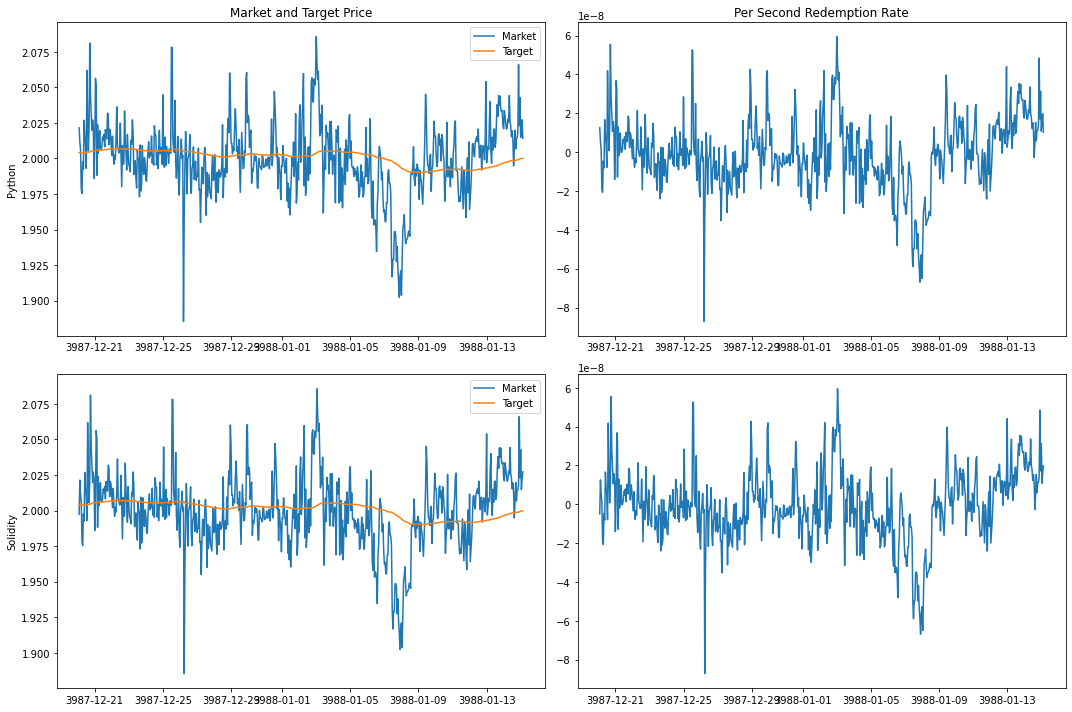

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(float)'])

fig.tight_layout()
plt.show()

<AxesSubplot:>

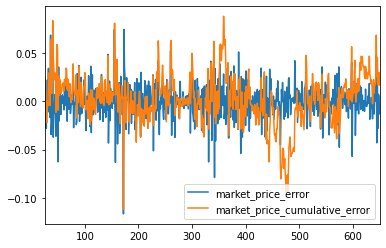

In [18]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

<AxesSubplot:>

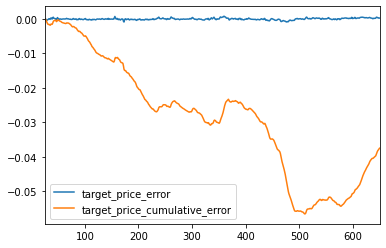

In [19]:
combined['target_price_error'] = combined['target_price'] - combined['RedemptionPrice(USD)']
combined['target_price_error'].plot(legend=True)
combined['target_price_cumulative_error'] = combined['target_price_error'].cumsum()
combined['target_price_cumulative_error'].plot(legend=True)

In [20]:
print(f'''
Max error: {combined['target_price_error'].max()}
Std. error: {combined['target_price_error'].std()}
Mean error: {combined['target_price_error'].mean()}
Abs. mean error: {combined['target_price_error'].abs().mean()}
''')


Max error: 0.0007341129542468572
Std. error: 0.00024660728461935454
Mean error: -5.994350066027717e-05
Abs. mean error: 0.00019417625554450082



In [21]:
combined['target_price_cumulative_error'].describe()

count     626.000000
unique    626.000000
top        -0.045945
freq        1.000000
Name: target_price_cumulative_error, dtype: float64